# CLIP

In [121]:
import numpy as np
import torch
from pkg_resources import packaging

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Torch version: 1.13.0a0+d0d6b1f


## Load datasets

In [122]:
from utils.mnist_preprocessing import *
from torchvision import transforms

# parameters
size_of_batch = 128

# dataset preparation
train_set = ColoredMNIST(root='./data',
                       env='train',
                       transform= transforms.Compose([transforms.ToTensor()]))

val_set = ColoredMNIST(root='./data',
                       env='val',
                       transform= transforms.Compose([transforms.ToTensor()]))

test_set = ColoredMNIST(root='./data',
                       env='test',
                       transform= transforms.Compose([transforms.ToTensor()]))

# dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=size_of_batch,
                                           shuffle=True,
                                           num_workers=10)

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=size_of_batch,
                                           shuffle=True,
                                           num_workers=10)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=size_of_batch,
                                           shuffle=True,
                                           num_workers=10)


Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists


## Choosing a model

In [123]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [124]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [125]:
model

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

## Image preprocessing

In [126]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fc116854d30>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text preprocessing

In [127]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [128]:
clip.tokenize("Hello World! My name is Patrick.")

tensor([[49406,  3306,  1002,   256,   607,  1981,   533,  5286,   269, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [129]:
clip.tokenize("Hello World! My name is Michelle.")

tensor([[49406,  3306,  1002,   256,   607,  1981,   533,  8625,   269, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Test performance of the clip model on the colored mnist dataset

In [130]:
# images in skimage to use and their textual descriptions

# Results in:
# Training accuracy:  33.85%
# Validation accuracy:  36.16%
# Test accuracy:  34.16%
descriptions2 = {
    "0": "a number with the value zero",
    "1": "a number with the value one",
    "2": "a number with the value two",
    "3": "a number with the value three",
    "4": "a number with the value four",
    "5": "a number with the value five",
    "6": "a number with the value six",
    "7": "a number with the value seven",
    "8": "a number with the value eight",
    "9": "a number with the value nine"
}

# Results in:
# Training accuracy:  33.85%
# Validation accuracy:  36.16%
# Test accuracy:  34.16%
descriptions = {
    "0": 'a photo of the number: "0".',
    "1": 'a photo of the number: "1".',
    "2": 'a photo of the number: "2".',
    "3": 'a photo of the number: "3".',
    "4": 'a photo of the number: "4".',
    "5": 'a photo of the number: "5".',
    "6": 'a photo of the number: "6".',
    "7": 'a photo of the number: "7".',
    "8": 'a photo of the number: "8".',
    "9": 'a photo of the number: "9".',
}

In [131]:
# exact same text tokens result in the same performance!
clip.tokenize(descriptions) == clip.tokenize(descriptions2)    

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, 

In [132]:
from utils.clip_utils import *

# len(=nr_of_batches)*batch_size=nr_of_samples
# len(val_loader)-1 full batches with a size of 128 images
# one last batch with the remaining <128 images
#(len(val_loader)-1) * 128 + 16 

asses_clip_performance(model, preprocess, train_loader, descriptions, dataset_name="Training")
asses_clip_performance(model, preprocess, val_loader, descriptions, dataset_name="Validation")
asses_clip_performance(model, preprocess, test_loader, descriptions, dataset_name="Test")

Training accuracy:  33.852
Validation accuracy:  36.16
Test accuracy:  34.16


## Setting up input images and texts

In [133]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

In [134]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

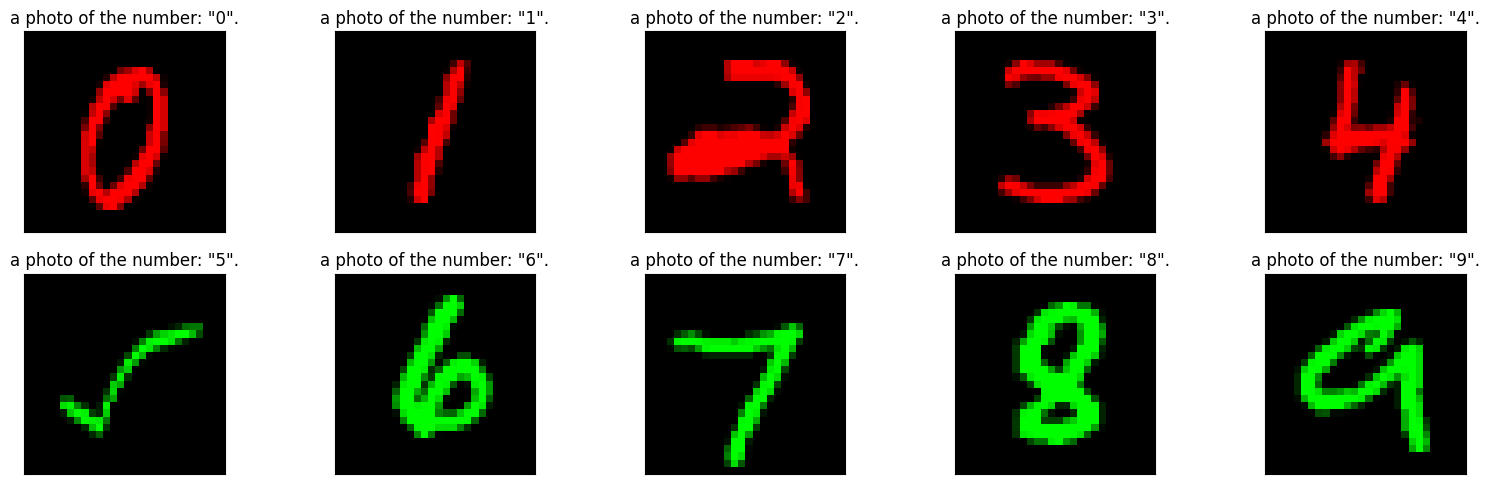

In [135]:
from utils.mnist_general import *

original_images, images, texts = show_examples_0_to_9(val_set, preprocess, descriptions)

In [136]:
similarity = clip_inference(model, images, texts)
show_cosine_similarities(similarity, images, texts)

NameError: name 'clip_inference' is not defined

## Zero-Shot Image Classification

In [ ]:
text_probs = clip_inference(model, images, texts, probabilities=True)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
show_text_img_probs(original_images, top_probs, top_labels, texts)